### 分析数据集

数据集名为`news-commentary-v6`，包含……五种语言的文本数据。打印数据集：

In [7]:
from pathlib import Path
DATA_DIR = Path("./data")
DATASET_NAME = 'news-commentary-v6'
lang = 'en'

with open(DATA_DIR / f'{DATASET_NAME}.{lang}') as f:
    text = f.read()

print(text[:200])

Musharraf's Last Act?
Desperate to hold onto power, Pervez Musharraf has discarded Pakistan's constitutional framework and declared a state of emergency.
His goal?
To stifle the independent judiciary 


可以看到数据组织为每行一句话，我们可以将整个文件作为一整个字符串进行分词器的训练和分词。

### 训练分词器


In [11]:
from itertools import product
from tokenizers import Tokenizer
from tokenizers.models import WordPiece, BPE, Unigram
from tokenizers.trainers import WordPieceTrainer, BpeTrainer, UnigramTrainer
from tokenizers.pre_tokenizers import Whitespace, Sequence, ByteLevel

VOCAB_SIZE = [1000, 3000, 5000]
NAME_TEMPLATE = "{lang}-{model}-{vocab_size}.json"
TOKENIZER_DIR = Path("./tokenizers")
if not TOKENIZER_DIR.exists():
    TOKENIZER_DIR.mkdir()
models = [WordPiece, BPE, Unigram]
trainers = [WordPieceTrainer, BpeTrainer, UnigramTrainer]


for vocab_size, (model, trainer) in product(VOCAB_SIZE, zip(models, trainers)):
    file_name = NAME_TEMPLATE.format(lang='en', model=model.__name__, vocab_size=vocab_size)
    tokenizer_path = TOKENIZER_DIR / file_name
    # if tokenizer_path.exists():
    #     print(f"Skipping {model.__name__} with vocab size {vocab_size}")
    #     continue
    print(f"Training {model.__name__} with vocab size {vocab_size}")
    tokenizer = Tokenizer(model())
    tokenizer.pre_tokenizer = ByteLevel()
    trainer = trainer(vocab_size=vocab_size, special_tokens=["[UNK]"])
    tokenizer.train([str(DATA_DIR / f'{DATASET_NAME}.{lang}')], trainer)
    tokenizer.save(tokenizer_path.as_posix())

Training WordPiece with vocab size 1000



Training BPE with vocab size 1000



Training Unigram with vocab size 1000


Training WordPiece with vocab size 3000



Training BPE with vocab size 3000



Training Unigram with vocab size 3000


Training WordPiece with vocab size 5000



Training BPE with vocab size 5000



Training Unigram with vocab size 5000




### 计算压缩率

WordPiece with vocab size 1000 has compression ratio 2.73
WordPiece with vocab size 3000 has compression ratio 3.76
WordPiece with vocab size 5000 has compression ratio 4.23
BPE with vocab size 1000 has compression ratio 2.99
BPE with vocab size 3000 has compression ratio 3.92
BPE with vocab size 5000 has compression ratio 4.35
Unigram with vocab size 1000 has compression ratio 2.69
Unigram with vocab size 3000 has compression ratio 3.48
Unigram with vocab size 5000 has compression ratio 3.75


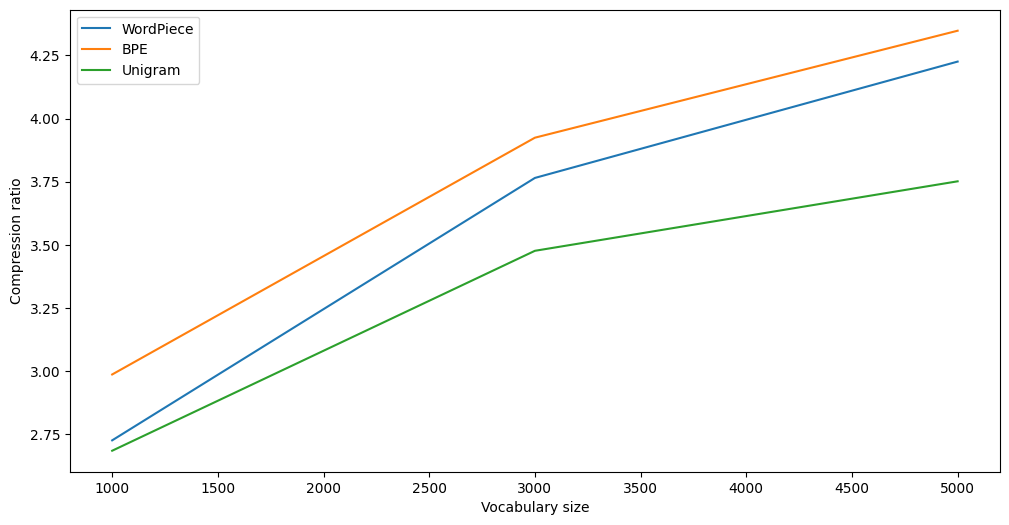

In [4]:
import matplotlib.pyplot as plt
from tokenizers import Tokenizer

def compute_compression_ratio(text, tokenizer: Tokenizer):
    num_utf8_bytes = len(text.encode('utf-8'))
    encoded_ids = tokenizer.encode(text)
    num_encoded_ids = len(encoded_ids.ids)
    return num_utf8_bytes / num_encoded_ids

# plot curves, grouped by model
fig, ax = plt.subplots(figsize=(12, 6))
for model in models:
    ratios = []
    for vocab_size in VOCAB_SIZE:
        file_name = NAME_TEMPLATE.format(lang=lang, model=model.__name__, vocab_size=vocab_size)
        tokenizer = Tokenizer.from_file(str(TOKENIZER_DIR / file_name))
        ratio = compute_compression_ratio(text, tokenizer)
        ratios.append(ratio)
        print(f"{model.__name__} with vocab size {vocab_size} has compression ratio {ratio:.2f}")
    ax.plot(VOCAB_SIZE, ratios, label=model.__name__)
ax.set_xlabel("Vocabulary size")
ax.set_ylabel("Compression ratio")
ax.legend()
plt.show()

### 其他实验
由于数据集内还包含其他语言——捷克语（cs）、德语（de）、西班牙语（es）和法语（fr），我们进一步研究不同分词器在不同语言上的效果。

Training WordPiece with vocab size 1000 of cs.



WordPiece with vocab size 1000 of cs has compression ratio 2.62
Training BPE with vocab size 1000 of cs.



BPE with vocab size 1000 of cs has compression ratio 2.91
Training Unigram with vocab size 1000 of cs.


Unigram with vocab size 1000 of cs has compression ratio 2.69
Training WordPiece with vocab size 3000 of cs.



WordPiece with vocab size 3000 of cs has compression ratio 3.56
Training BPE with vocab size 3000 of cs.



BPE with vocab size 3000 of cs has compression ratio 3.78
Training Unigram with vocab size 3000 of cs.


Unigram with vocab size 3000 of cs has compression ratio 3.45
Training WordPiece with vocab size 5000 of cs.



WordPiece with vocab size 5000 of cs has compression ratio 4.05
Training BPE with vocab size 5000 of cs.



BPE with vocab size 5000 of cs has compression ratio 4.25
Training Unigram with vocab size 5000 of cs.


Unigram with vocab size 5000 of cs has compression ratio 3.82
Training WordPiece with v

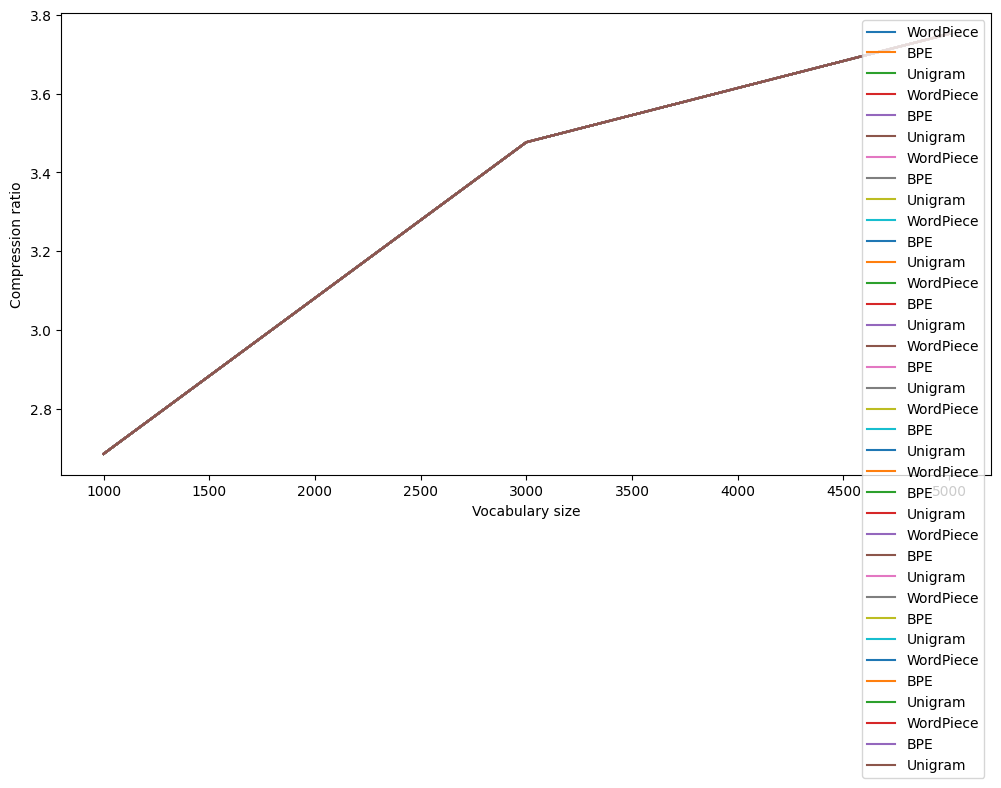

In [ ]:
LANGUAGES = ['cs', 'de', 'en', 'es', 'fr']

fig, ax = plt.subplots(figsize=(12, 6))
for lang, vocab_size, (model, trainer) in product(LANGUAGES, VOCAB_SIZE, zip(models, trainers)):
    with open(DATA_DIR / f'{DATASET_NAME}.{lang}') as f:
        text = f.read()
    file_name = NAME_TEMPLATE.format(lang=lang, model=model.__name__, vocab_size=vocab_size)
    tokenizer_path = TOKENIZER_DIR / file_name
    if tokenizer_path.exists():
        print(f"Skipping {model.__name__} with vocab size {vocab_size} of {lang}.")
        continue
    print(f"Training {model.__name__} with vocab size {vocab_size} of {lang}.")
    tokenizer = Tokenizer(model())
    tokenizer.pre_tokenizer = Whitespace()
    trainer = trainer(vocab_size=vocab_size, special_tokens=["[UNK]"])
    tokenizer.train([str(DATA_DIR / f'{DATASET_NAME}.{lang}')], trainer)
    tokenizer.save(tokenizer_path.as_posix())
    ratio = compute_compression_ratio(text, tokenizer)
    
    print(f"{model.__name__} with vocab size {vocab_size} of {lang} has compression ratio {ratio:.2f}")
    ax.plot(VOCAB_SIZE, ratios, label=model.__name__)
    
ax.set_xlabel("Vocabulary size")
ax.set_ylabel("Compression ratio")
ax.legend()
plt.show()